In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
from pandas import ExcelFile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#read data
df = pd.read_csv('/content/drive/My Drive/PROJECT/BDC (private)/BDC/DATASET/dataset_penyisihan_bdc_2024.csv', sep=";")
df.head()

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


In [5]:
# Function to clean data
def clean_tweet(tweet):
    import re

    # Define regex pattern to match usernames, hyperlinks, and old style retweets
    pattern = r'(@[\w/+=]+)|(https?://\S+)|(\[RE\s+\w+\])'

    # Remove usernames, hyperlinks, and old style retweets
    tweet = re.sub(pattern, '', tweet)

    # Remove numbers
    tweet = re.sub('[0-9]+', '', tweet)

    # Remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)

    # Menghapus teks retweet gaya lama "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)

    # Remove special characters using regular expressions (re) hashtag
    tweet = re.sub(r'[^\w\s]', '', tweet)

    return tweet

# Apply the cleaning function to every row in the 'text' column of the DataFrame
df['text'] = df['text'].apply(clean_tweet)


In [6]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.2 MB/s eta 0:00:00


In [8]:
#import stopword
from nltk.corpus import stopwords
stopwords_indonesia = stopwords.words('indonesian')

#import sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#tokenize
from nltk.tokenize import TweetTokenizer

# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(', ':\U0001F92D'
    ])

# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)

In [9]:
# Remove emoji
def remove_emojis(tweet):
    """
    Removes emojis from text while preserving punctuation, special characters,
    and characters from various languages (Korean, Chinese, Russian, German, Spanish, etc.).

    Args:
        tweet (str): The text to remove emojis from.

    Returns:
        str: The text with emojis removed.
    """

    # Unicode emoji character ranges (excluding flags)
    emoji_ranges = [
        u"\U0001F600-\U0001F64F",  # emoticons
        u"\U0001F300-\U0001F5FF",  # symbols & pictographs
        u"\U0001F680-\U0001F6FF",  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"   # miscellaneous symbols
    ]

    # Combine emoji ranges into a single pattern
    emoji_pattern = "|".join(emoji_ranges)

    # Create a pattern that matches any character except letters, numbers, punctuation,
    # whitespace, and characters from various languages (excluding flags)
    allowed_chars = r"[a-zA-Z0-9\s\-.,!?:;\(\)\[\]\{\}]"
    non_emoji_pattern = f"{allowed_chars}"

    # Combine the emoji and non-emoji patterns into a single pattern
    combined_pattern = f"(^{non_emoji_pattern})|({emoji_pattern})"

    # Remove emojis while keeping other characters
    return re.sub(combined_pattern, r"\1", tweet, flags=re.UNICODE)

df['text'] = df['text'].apply(remove_emojis)

In [10]:
!pip install emoji
import emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.5 MB/s eta 0:00:00


In [11]:
# Remove invalid emoji
def remove_invalid_emojis(tweet):
    # This regex pattern matches all emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )

    # Find all emojis in the text
    emojis_found = emoji_pattern.findall(tweet)

    # Filter valid emojis
    valid_emojis = [e for e in emojis_found if e in emoji.UNICODE_EMOJI['en']]

    # Replace invalid emojis with empty string
    for e in emojis_found:
        if e not in valid_emojis:
            tweet = tweet.replace(e, '')

    return tweet

df['text'] = df['text'].apply(remove_invalid_emojis)

In [12]:
#Remove incorrect emoji
def incorrect_emoji(tweet):
    # Define patterns for incorrect encodings and non-standard characters
    encoding_pattern = re.compile(r"Ã[A-Za-z0-9ÂŒÂˆÂŠÂœ]+")

    # Remove these patterns from the text
    tweet = re.sub(encoding_pattern, '', tweet)

    # Remove any remaining non-standard characters
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)

    return tweet

df['text'] = df['text'].apply(incorrect_emoji)

In [13]:
#remove duplicate with same label
df = df.drop_duplicates(subset=['text', 'label'], keep='first')

In [14]:
#remove duplicate with different label
df = df.drop_duplicates(subset=['text'], keep= False)

In [15]:
pip install fuzzywuzzy python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 39.1 MB/s eta 0:00:00


In [16]:
pip install indonlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.5 MB/s eta 0:00:00


In [17]:
from indoNLP.preprocessing import replace_slang

# Apply replace_slang to the 'text' column
df['text'] = df['text'].apply(lambda x: replace_slang(str(x)))

# Display the first few rows of the DataFrame to verify the changes
print(df.head())


                                                text             label
0  Kunjungan Prabowo ini untuk meresmikan dan men...  Sumber Daya Alam
1  Anies dapat tepuk tangan meriah saat jadi Rekt...           Politik
2   memang benar sih pendukung  ada yang goblok b...         Demografi
3  Sewaktu anies bersikap kritis ke kinerja pak p...           Politik
4  Anies Baswedan Harap ASN termasuk TNI dan Polr...           Politik


In [18]:
from indoNLP.preprocessing import replace_word_elongation

# Apply replace_word_elongation function to the 'text' column of your DataFrame
df['text'] = df['text'].apply(replace_word_elongation)


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Download stopwords for the Indonesian language
nltk.download('stopwords')
nltk.download('punkt')

# Tokenize the text
df['text'] = df['text'].apply(lambda x: word_tokenize(str(x).lower()))  # Convert to lowercase

# Remove stopwords from tokens
stop_words = set(stopwords.words('indonesian'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

# Function to remove stopwords from list of words
def remove_stopwords(words):
    factory = StopWordRemoverFactory()
    stopword_remover = factory.create_stop_word_remover()
    cleaned_words = stopword_remover.remove(' '.join(words)).split()
    return cleaned_words

# Apply the remove_stopwords function to each list of words in the 'text' column
df['text'] = df['text'].apply(remove_stopwords)

# Join the list of words back into a string
df['text'] = df['text'].apply(' '.join)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#tokenisasi

import pandas as pd
import nltk


# Download stopwords for Indonesian language
nltk.download('stopwords')
nltk.download('punkt')

# Tokenize the text
df['text'] = df['text'].apply(lambda x: word_tokenize(str(x).lower()))  # Convert to lowercase

# Remove stopwords from tokens
stop_words = set(stopwords.words('indonesian'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#find the most use word

# Tokenize the text and count word frequencies
all_words = ' '.join([' '.join(text) for text in df['text']]).lower()
tokens = word_tokenize(all_words)
word_freq = Counter(tokens)

# Display the most common words
most_common_words = word_freq.most_common(10)  # Change 10 to the desired number of most common words
print("Most common words:")
for word, frequency in most_common_words:
    print(word, frequency)

Most common words:
anies 1880
ganjar 1760
prabowo 1561
pranowo 849
mahfud 813
indonesia 622
jnk 598
ganjarmahfud 596
ganjarpranowopilihanumat 558
capres 543


In [ ]:
#Remove kata-kata yang belum terdeteksi

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# List of words to remove
words_to_remove = [
    'ganjarmahfudrebound', 'md', 'baswedan', 'gibran', 'prabowogibran', 'orang',
    'subianto', 'amin', 'ga', 'no', 'amp', 'gm', 'nya', 'imin', 'aniesmuhaimin', 'prof', 'utk', 'lbihbaik',
    'beliau', 'abah', 'mas', 'pak', 'aja', 'kalo', 'presiden', 'gak', 'lu', 'gw', 'gue', 'lu', 'sm', 'w', 'doang', 'mah', 'ku',
    'retweet', 'reply', 'sih'
]

# Add words from most_common_words to words_to_remove
for word, _ in most_common_words:
    words_to_remove.append(word)

def remove_specific_words(text):
    cleaned_words = []
    for word in text:
        # Check if the word is in the list of words to remove
        if word.lower() in words_to_remove:
            continue
        cleaned_words.append(word)
    return cleaned_words

df['text'] = df['text'].apply(remove_specific_words)


In [ ]:
class_counts = df['label'].value_counts()

# Menampilkan hasil
print("Frekuensi data per kelas:")
print(class_counts)

# Jika Anda ingin menampilkan dalam bentuk DataFrame untuk tampilan yang lebih baik
class_counts_df = class_counts.reset_index()
class_counts_df.columns = ['Label', 'Frequency']
print(class_counts_df)


Frekuensi data per kelas:
label
Politik                    2861
Sosial Budaya               384
Ekonomi                     268
Pertahanan dan Keamanan     257
Ideologi                    253
Sumber Daya Alam            134
Demografi                    55
Geografi                     19
Name: count, dtype: int64
                     Label  Frequency
0                  Politik       2861
1            Sosial Budaya        384
2                  Ekonomi        268
3  Pertahanan dan Keamanan        257
4                 Ideologi        253
5         Sumber Daya Alam        134
6                Demografi         55
7                 Geografi         19


<ipython-input-77-8fc9a6f6e22a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Frequency', data=class_counts, palette='viridis')


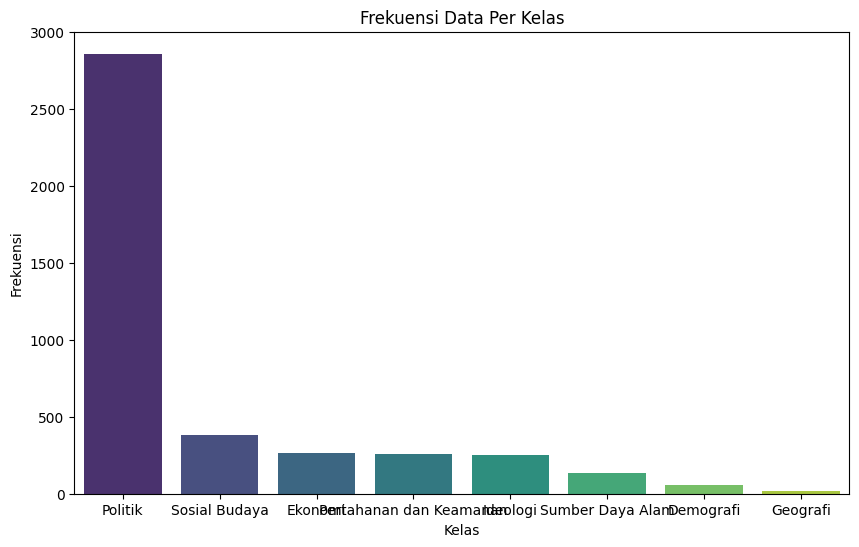

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Misalkan DataFrame Anda adalah df
# Menghitung frekuensi data per kelas
class_counts = df['label'].value_counts().reset_index()
class_counts.columns = ['Label', 'Frequency']

# Menampilkan hasil dalam bentuk diagram batang
plt.figure(figsize=(10, 6))
sns.barplot(x='Label', y='Frequency', data=class_counts, palette='viridis')
plt.title('Frekuensi Data Per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Frekuensi')
plt.show()


In [ ]:
df.head()

,text,label
0,"[kunjungan, meresmikan, menyerahkan, proyek, b...",Sumber Daya Alam
1,"[tepuk, tangan, meriah, rektor, mewajibkan, ma...",Politik
2,"[pendukung, goblok, pendukung, ridwan, kamil, ...",Demografi
3,"[bersikap, kritis, kinerja, dianggap, sopan, d...",Politik
4,"[harap, asn, tni, polri, pegang, sumpahnya, pe...",Politik


In [ ]:
# Simpan DataFrame ke file CSV
df.to_csv('data.csv', index=False)


from google.colab import files
# Mengunduh file CSV
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>